# K-Anonymity 
<p align="justify">$\qquad$ <b>k-anonymity</b> -модель, которая позволяет снижать риски повторной идентификации путем объединения атрибутов в группы, описывающие не менее $k$ людей. Предположим, что имеется набор из  $N$ строк/записей. Каждая запись состоит из  $D$ полей/атрибутов, из которых $X_i$ ($i \in [0,D]$) не содержат конфиденциальной информации (non-sensitive) о физическом лице, примером таких атрибутов является возраст, пол, почтовый код и т.п. Однако,  это подмножество атрибутов может в совокупности указывать на конкретное лицо в данной группе.Такие атрибуты, в совокупности указывающие на конкретную персону называются <b>квази-идентификаторами</b> ("quasi-identifiers"), а их комбинация - <b>супер-идентификатор</b> ("super-identifier"), который может указывать на уникальную персону в достаточно большом наборе данных (т.е. комбинация пола, возраста и почтового кода ведет к выделению отдельной личности). </p>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel("marketing_case_v.0.7.xlsx", sheet_name="A1", engine = 'openpyxl')
df.tail(10)


,Локальное время покупок,Широта,Долгота,Общая сумма покупок,Код региона,Часовой пояс,Кол-во товаров в покупке,Бренды,Категория
499990,2020-02-15T23:46+00:03,44.426539,55.631427,4389,38,UTC+5,1,NETGEAR,Антенны для Wi-Fi и 3G
499991,2020-02-19T09:27+00:03,44.428760,55.656080,5300,38,UTC+5,1,Kingston,Оперативная память
499992,2020-02-06T20:03+00:03,44.427669,55.636085,28854,38,UTC+5,1,HP,Ноутбуки
499993,2020-02-13T20:54+00:03,44.412713,55.647121,27390,38,UTC+5,3,LG,Монитор
499994,2020-03-04T22:14+00:03,44.431904,55.630821,56067,38,UTC+5,3,Lenovo,Ноутбуки
499995,2020-02-01T01:50+00:03,44.413535,55.641065,38336,38,UTC+5,4,LG,Монитор
499996,2020-01-11T06:01+00:03,44.431067,55.621626,81886,38,UTC+5,2,Acer,Ноутбуки
499997,2020-01-16T04:13+00:03,44.418827,55.643441,330292,38,UTC+5,4,HP,Монитор
499998,2020-02-09T06:17+00:03,44.435559,55.657311,10310,38,UTC+5,5,Bradex,Подставки для ноутбуков
499999,2020-01-11T05:16+00:03,44.410798,55.602325,34780,38,UTC+5,4,BenQ,Монитор


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Локальное время покупок   500000 non-null  object 
 1   Широта                    500000 non-null  float64
 2   Долгота                   500000 non-null  float64
 3   Общая сумма покупок       500000 non-null  int64  
 4   Код региона               500000 non-null  int64  
 5   Часовой пояс              500000 non-null  object 
 6   Кол-во товаров в покупке  500000 non-null  int64  
 7   Бренды                    499751 non-null  object 
 8   Категория                 500000 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 34.3+ MB


Currently each row is unique

In [3]:
'Duplicates == ' + str(df.shape[0] - df.drop_duplicates().shape[0])

'Duplicates == 0'

#### Модель $k$-anonimity и риски повторной идентификации

<p align="justify">$\qquad$ В дополнение подразумевается, что кроме квази-идентификаторов набор данных может содержать некоторые данные напрямую указывающие на личность (например, ИНН) - <b>прямые идентификаторы</b> ("direct-identificatotrs"), а также по крайней мере один атрибут представляющий чувствительную информацию - например, уровень дохода ("income") или сведения о болезни. Модель нацелена на защиту этой чувствительной информации. В рамках такой защиты записи подвергаются методам обезличивания - <b>обобщению</b> ("generalization") или подавлению ("suppression"), цель этих методов разрушить информацию таким образом, чтобы снизить количество строк с одинаковыми квази-атрибутами (так называемые классы эквивалентности). Объем минимального класса эквивалентности (количество записей с одинаковыми занчениями квази-идентификаторов) обратно пропорционален вероятности риска повторной идентификации и может служить числовой характеристикой метода.</p>


<p align="justify">$\qquad$ Применение методов обезличивания ведет к тому, что полезная информация в обезличенных наборах данных становится менеее качественной - для измерения уровня этого качества используются специальные метрики <b>расчета полезности</b> ("utility"). Суть модели - нахождение баланса между риском повторной идентификации с одной стороны и полезностью набора  данных - с другой.</p>

<p align="justify">$\qquad$ В первом приближении модель k-anonymity  требует выделения квази-идентификаторов ("QID") и вычисления для них <b>размеров классов-эквивалентности</b>  $k$ строк/физических лиц, затем итерационное применение методов обезличивания (включающих подавление строк или ячеек, обобщение значений), между которыми следует анализ получившегося набора и уточнение параметров методов обезличивания. В результате это защищает отдельных людей, сводя к минимому информацию об отдельном человеке, оставляя злоумышленнику ("adversary") только информацию о принадлежности данного человека к определенной группе.  Хотя получающийся набор не является точным, он все еще годится для целей анализа и построения моделей машинного обучения. В ряде случаев надо решать не только проблему обезличивания, но и иного подхода к идентификации, например, для решения задач, в которых обобщенные данные не могут использоваться напрямую.</p>


In [4]:
def k_anonymous(data, columns):
  ## Возьмите фрейм данных, верните значение k-anonymity
  ## Агрегируйте по именам столбцов и возьмите ненулевой минимум каждой строки
  aggregrate = data.groupby(columns).count().apply(lambda x : set(x) - set({0}),axis = 1)
  aggregrate = aggregrate.apply(lambda x : 0 if x == set() else min(x))
  return min(aggregrate)
print(' k-anonymity = ' + str(k_anonymous(df, [
    'Локальное время покупок',
    'Широта',
    'Долгота',
    'Общая сумма покупок',
    'Код региона',
    'Часовой пояс',
    'Бренды',
    'Категория'])))

 k-anonymity = 1


#### Графики подсчета этих типов данных показаны ниже.

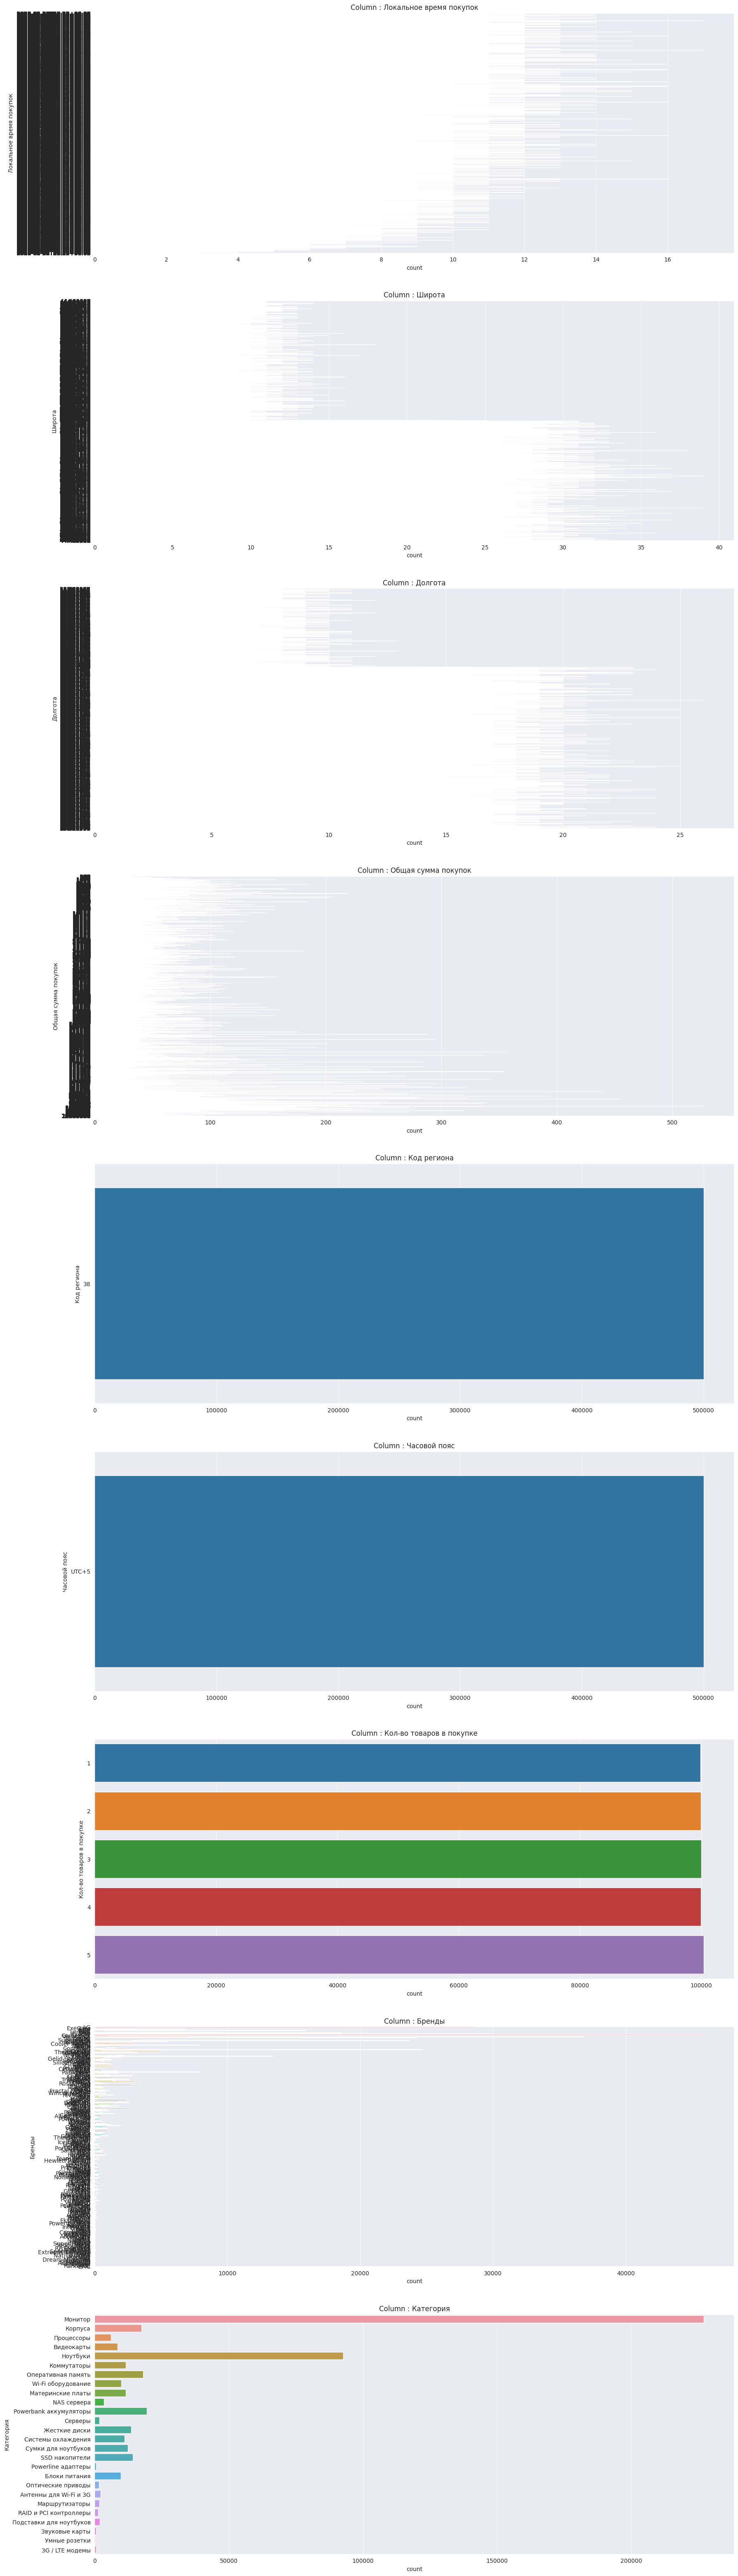

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['Локальное время покупок',
            'Широта',
            'Долгота',
            'Общая сумма покупок',
            'Код региона',
            'Часовой пояс',
            'Кол-во товаров в покупке',
            'Бренды',
            'Категория']

fig, ax = plt.subplots(len(columns), figsize = (20,80))
for i in range(len(columns)):
  ax[i].set_title('Column : ' + str(columns[i]))
  sns.countplot(y = columns[i], data = df, ax = ax[i])